In [275]:
from qiskit import *
from qiskit.circuit import Parameter
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer, transpile

import numpy as np
import matplotlib.pyplot as plt

simulator = Aer.get_backend('aer_simulator')

c:\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


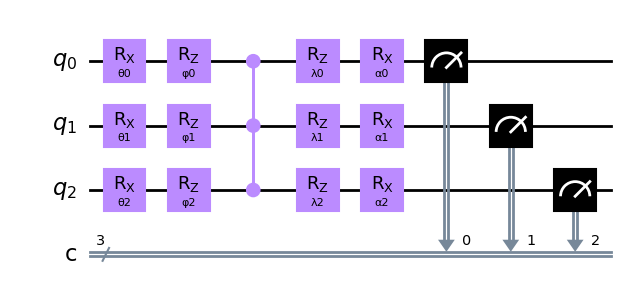

In [276]:
qc = QuantumCircuit(3, 3)

# Create 3 parameters theta_0, theta_1, theta_2
theta_0 = Parameter('θ0')
theta_1 = Parameter('θ1')
theta_2 = Parameter('θ2')
# Create 3 parameters phi_0, phi_1, phi_2
phi_0 = Parameter('φ0')
phi_1 = Parameter('φ1')
phi_2 = Parameter('φ2')
# Create 3 parameters lambda_0, lambda_1, lambda_2
lambda_0 = Parameter('λ0')
lambda_1 = Parameter('λ1')
lambda_2 = Parameter('λ2')
# Create 3 parameters alpha_0, alpha_1, alpha_2
alpha_0 = Parameter('α0')
alpha_1 = Parameter('α1')
alpha_2 = Parameter('α2')

# Apply the RX gate to qubit 0, 1, 2 using the parameter theta_0, theta_1, theta_2
qc.rx(theta_0, 0)
qc.rx(theta_1, 1)
qc.rx(theta_2, 2)
# Apply the RZ gate to qubit 0, 1, 2 using the parameter phi_0, phi_1, phi_2
qc.rz(phi_0, 0)
qc.rz(phi_1, 1)
qc.rz(phi_2, 2)

# Apply a ccz gate to qubits 0, 1, 2
qc.ccz(0, 1, 2)

# Apply the RZ gate to qubit 0, 1, 2 using the parameter lambda_0, lambda_1, lambda_2
qc.rz(lambda_0, 0)
qc.rz(lambda_1, 1)
qc.rz(lambda_2, 2)
# Apply the RX gate to qubit 0, 1, 2 using the parameter alpha_0, alpha_1, alpha_2
qc.rx(alpha_0, 0)
qc.rx(alpha_1, 1)
qc.rx(alpha_2, 2)

# Measure qubit 0, 1, 2
qc.measure(0, 0)
qc.measure(1, 1)
qc.measure(2, 2)

# Draw the circuit
qc.draw('mpl')

In [277]:
# Create a function that takes the parameters and returns the circuit with the parameters setup
def parametrized(*angles):
    circ_par = qc.assign_parameters({theta_0: angles[0], theta_1: angles[1], theta_2: angles[2], phi_0: angles[3], phi_1: angles[4], phi_2: angles[5], lambda_0: angles[6], lambda_1: angles[7], lambda_2: angles[8], alpha_0: angles[9], alpha_1: angles[10], alpha_2: angles[11]})
    return circ_par

In [278]:
# Create a random array of angles
angles_init = np.random.rand(12)*2*np.pi
angles_init

array([3.14460062, 4.13832339, 0.73615639, 3.87402691, 1.35370114,
       1.87694055, 3.04208496, 2.29274753, 3.83445882, 2.05132098,
       3.80425912, 6.25736128])

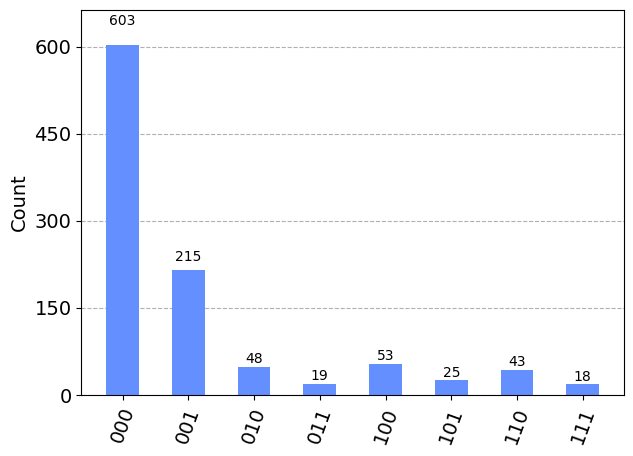

In [279]:
test = parametrized(*angles_init)

# transpile the circuit and execute it on the simulator
qc_transpiled = transpile(test)
result = simulator.run(qc_transpiled).result()
counts = result.get_counts(qc_transpiled)

# Plot the histogram
plot_histogram(counts)

In [280]:
counts

{'000': 603,
 '001': 215,
 '110': 43,
 '101': 25,
 '111': 18,
 '010': 48,
 '100': 53,
 '011': 19}

In [281]:
def cost_function(input, counts_test):
    comp = 0
    num_0 = 0
    for i in range(len(input)):
        if input[i] == '0':
            num_0 += 1
    if not num_0 > 1:
        comp = 7
    tot = 0
    for key in counts_test:
        tot += counts_test[key]
        if int(key,2) == comp:
            ok = counts_test[key]

    #print(f"Cost report: {input} -> {comp} vs {sum/tot}")
    return tot/ok

In [282]:
cost_function('000', counts)

1.6981757877280266

In [283]:
all_inputs = ['000', '001', '010', '011', '100', '101', '110', '111']

In [284]:
def cost_on_all_inputs(*angles):
    tot = 0
    for i in all_inputs:
        qc_test = QuantumCircuit(3, 3)
        for j in range(len(i)):
            if i[j] == '1':
                qc_test.x(2-j)
        qc_test.compose(parametrized(*angles), inplace=True)
        #print(i)
        #display(qc_test.draw('mpl'))
        trans = transpile(qc_test)
        res = simulator.run(trans).result()
        counts = res.get_counts()
        tot += cost_function(i, counts)**2

    return tot

cost_on_all_inputs(*angles_init)

2311.608329654156

In [290]:
def optimize(init_angles, step, iter_size):
    angles = init_angles
    for i in range(iter_size):
        print('Iteration', i)
        cst = cost_on_all_inputs(*angles)
        print('New cost:', cst)
        for j in range(len(angles)):
            angles[j] += step
            tcs = cost_on_all_inputs(*angles)
            if cst < tcs:
                angles[j] -= step
            else:
                cst = tcs
        print('Current cost:', cst)
    return angles

In [291]:
test_angles = optimize(np.random.rand(12)*2*np.pi, 0.03, 4)
print(test_angles)

Iteration 0
New cost: 1261.2802568266945
Current cost: 1012.3067331199202
Iteration 1
New cost: 1265.0439516653064
Current cost: 1015.1396381148438
Iteration 2
New cost: 892.5404897437884
Current cost: 892.5404897437884
Iteration 3
New cost: 1227.8144515232393
Current cost: 988.9535488686404
[0.83077018 5.68663497 3.86927531 2.70096808 5.99505051 0.07326057
 3.17101384 1.24422249 4.67931467 4.78197336 1.65644292 2.8601005 ]


000


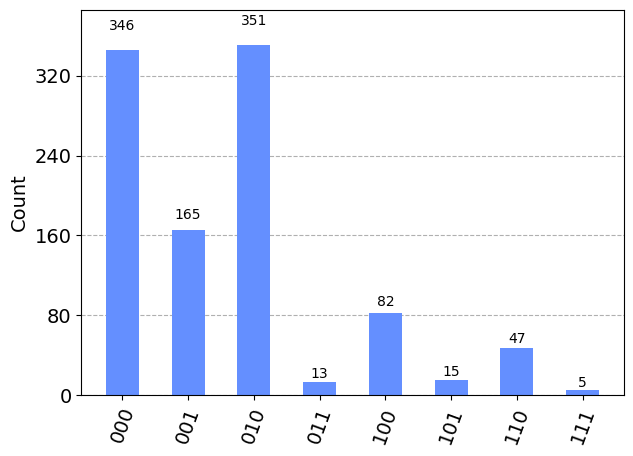

001


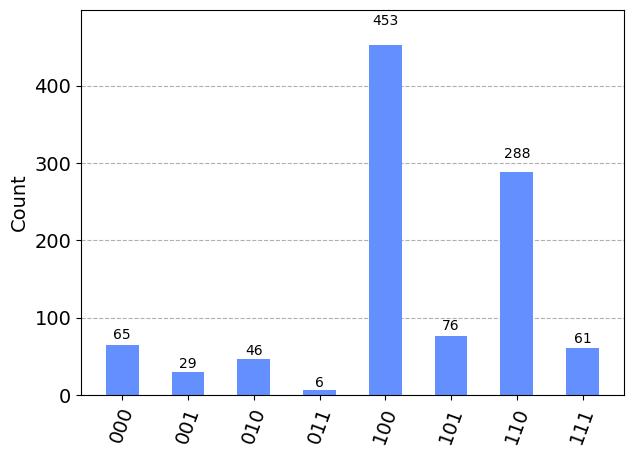

010


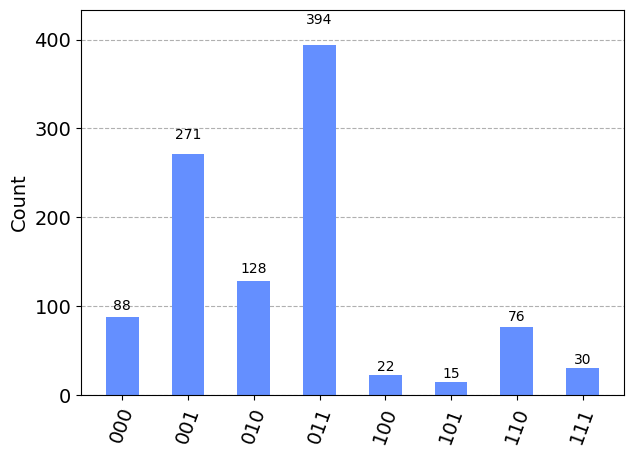

011


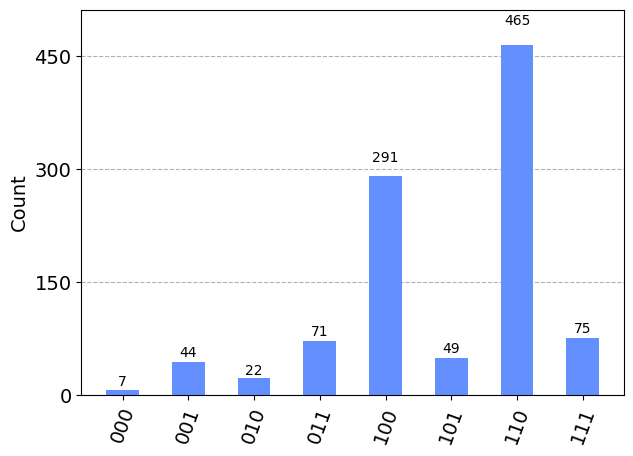

100


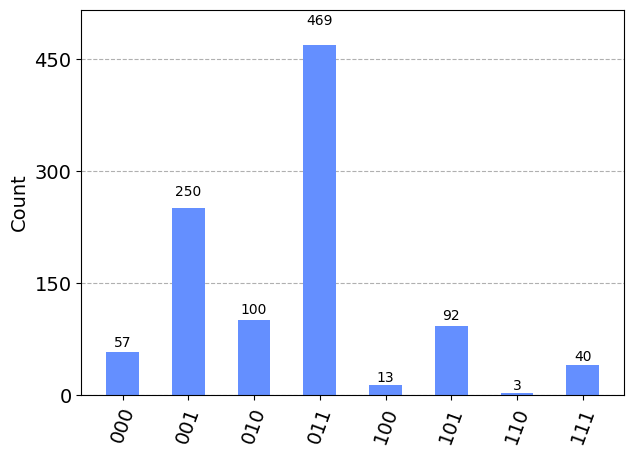

101


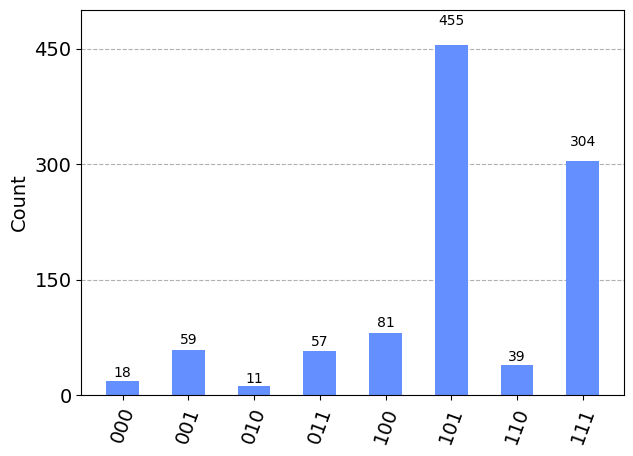

110


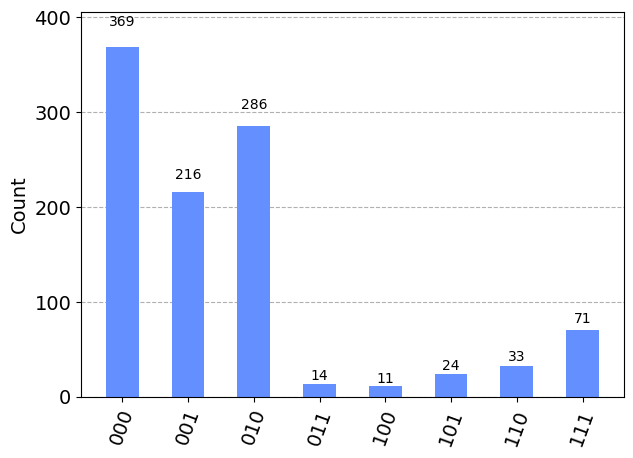

111


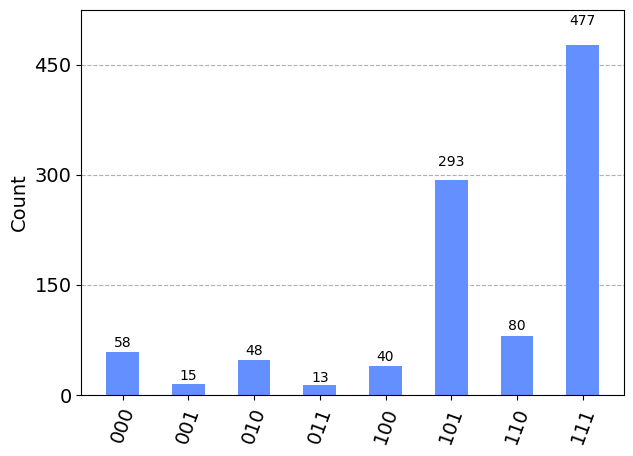

In [292]:
for i in all_inputs:
        qc_test = QuantumCircuit(3, 3)
        for j in range(len(i)):
            if i[j] == '1':
                qc_test.x(j)
        qc_test.compose(parametrized(*test_angles), inplace=True)
        trans = transpile(qc_test)
        res = simulator.run(trans).result()
        counts = res.get_counts()
        print(i)
        display(plot_histogram(counts))